Index(['Q10_ 0', 'Q10_ 1', 'Q10_ 2', 'Q10_ 3', 'Q10_ Cold Drinks',
       'Q10_ Pastries', 'Q10_ pastries', 'Q10_0', 'Q10_1', 'Q10_2',
       'Q10_Coffee', 'Q10_Coffee Pastries', 'Q10_coffee'],
      dtype='object')
Index(['Q19_ 1', 'Q19_ 2', 'Q19_ 4', 'Q19_ 6', 'Q19_ 6]', 'Q19_0', 'Q19_1',
       'Q19_2', 'Q19_4', 'Q19_6', 'Q19_[1'],
      dtype='object')


/Users/giuliaserrerti/Library/Python/3.9/lib/python/site-packages/scipy/stats/contingency.py:459: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
/Users/giuliaserrerti/Library/Python/3.9/lib/python/site-packages/scipy/stats/contingency.py:459: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
/Users/giuliaserrerti/Library/Python/3.9/lib/python/site-packages/scipy/stats/contingency.py:459: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
/Users/giuliaserrerti/Library/Python/3.9/lib/python/site-packages/scipy/stats/contingency.py:459: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
/Users/giuliaserrerti/Library/Python/3.9/lib/python/site-packages/scipy/stats/contingency.py:459: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_

             Q1        Q2        Q3        Q4        Q5        Q6        Q7  \
Q1     1.000000  0.291636  0.187218  0.331999  0.153393  0.284428  0.216193   
Q2     0.291636  1.000000  0.361830  0.362653  0.342040  0.377399  0.089607   
Q3     0.187218  0.361830  1.000000  0.357989  0.552707  0.236085  0.259018   
Q4     0.331999  0.362653  0.357989  1.000000  0.674313  0.667152  0.288826   
Q5     0.153393  0.342040  0.552707  0.674313  1.000000  0.569941  0.300848   
Q6     0.284428  0.377399  0.236085  0.667152  0.569941  1.000000  0.293708   
Q7     0.216193  0.089607  0.259018  0.288826  0.300848  0.293708  1.000000   
Q8     0.043334  0.026629  0.055570  0.178189  0.046603  0.047072  0.013825   
Q9     0.133345  0.406639  0.549802  0.950854  0.936948  0.607259  0.280114   
Q11    0.008003  0.255117  0.472066  0.090909  0.437666  0.092446  0.314754   
Q12         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
Q13         NaN       NaN       NaN       NaN       

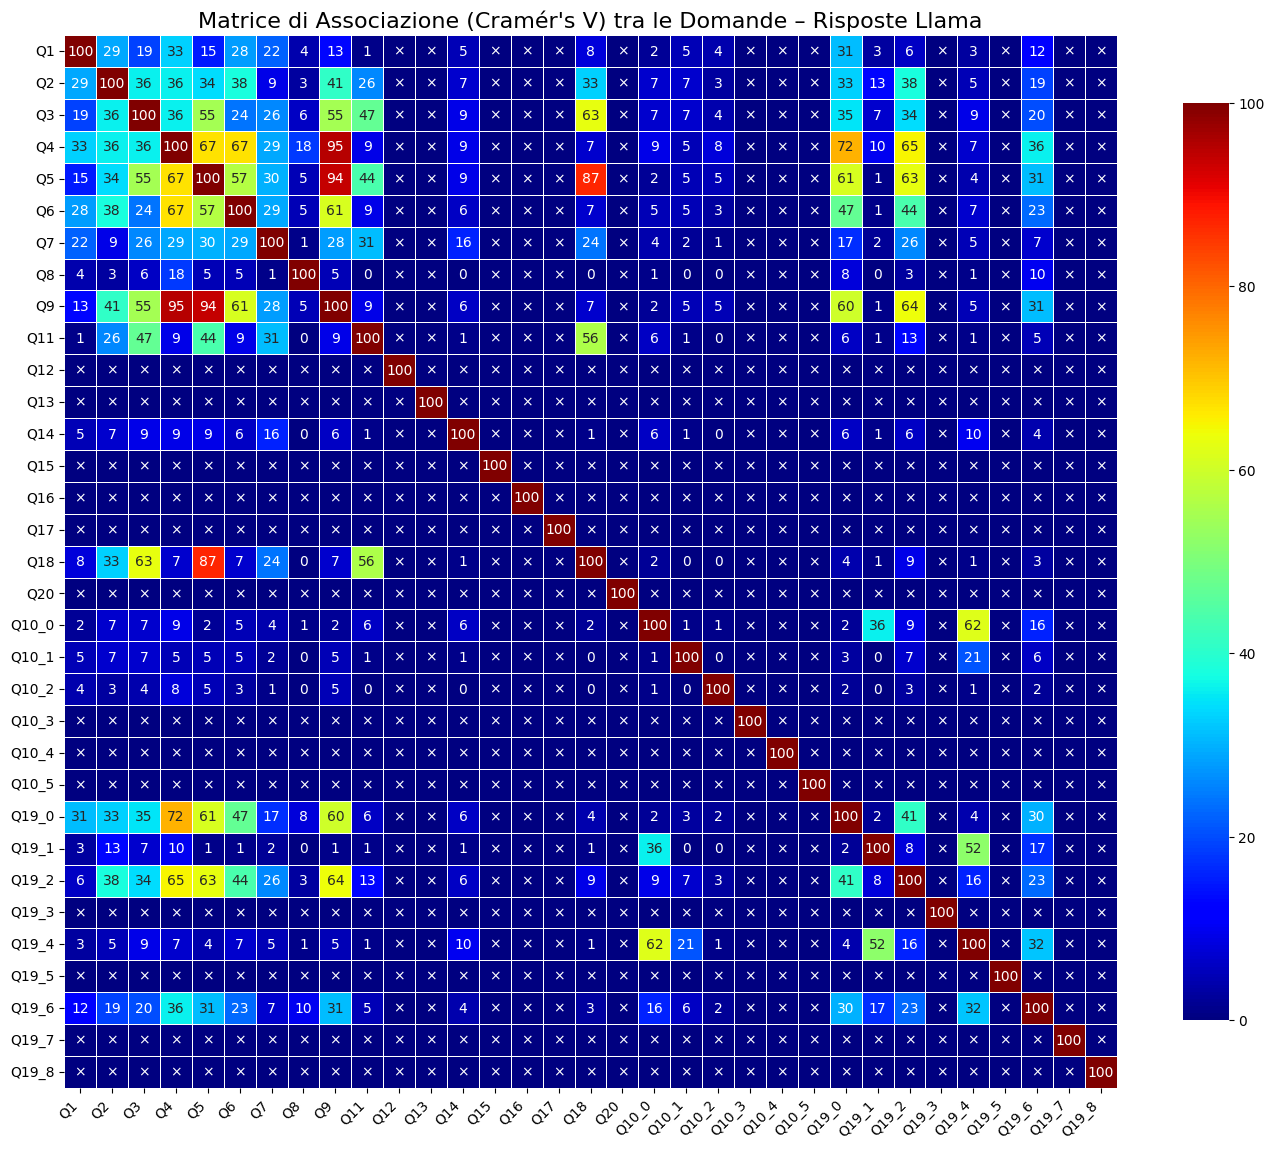

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
from scipy.stats.contingency import association

df = pd.read_csv("meta_lama_3_3_70b_instruct_answers.csv")

def explode_multichoice(df, column, prefix, expected_values=None):
    """
    Esplode una colonna multirisposta in colonne binarie.
    expected_values: lista di opzioni che devono essere presenti come colonne, anche se non appaiono nei dati.
    """
    exploded = df[column].dropna().astype(str).str.get_dummies(sep=',')
    
    # Rinomina le colonne
    exploded.columns = [f"{prefix}_{c}" for c in exploded.columns]
    print(exploded.columns)
    
    # Aggiungi colonne mancanti con zeri
    if expected_values is not None:
        for val in expected_values:
            colname = f"{prefix}_{val}"
            if colname not in exploded.columns:
                exploded[colname] = 0

        # Riordina le colonne per consistenza
        exploded = exploded[[f"{prefix}_{val}" for val in expected_values]]

    return exploded


# Estrai colonne da Q1 a Q20
cols = [f"Q{i}" for i in range(1, 21)]

# Colonne normali e multirisposta
multi_cols = ["Q10", "Q19"]
single_cols = [col for col in cols if col not in multi_cols]

df_single = df[single_cols]

# Tutti i valori attesi (possono venire dal dominio originale del dataset)
q10_values = ['0', '1', '2', '3', '4', '5']
q19_values = ['0', '1', '2', '3', '4', '5', '6', '7', '8']

# Esplodi le colonne con tutte le opzioni attese
df_q10 = explode_multichoice(df, 'Q10', 'Q10', expected_values=q10_values)
df_q19 = explode_multichoice(df, 'Q19', 'Q19', expected_values=q19_values)

# Combina tutto in un unico DataFrame
df_combined = pd.concat([df_single.reset_index(drop=True), df_q10, df_q19], axis=1)

# Ora calcola la matrice di associazione tra tutte le colonne
columns = df_combined.columns
results = pd.DataFrame(index=columns, columns=columns, dtype=float)

for col1 in columns:
    for col2 in columns:
        if col1 == col2:
            results.loc[col1, col2] = 1.0
        else:
            contingency = pd.crosstab(df_combined[col1], df_combined[col2])
            results.loc[col1, col2] = association(contingency.values, method="cramer")

# Visualizza la matrice arrotondata
print(results)

import matplotlib.pyplot as plt
import seaborn as sns

# Crea maschera per NaN
mask_nan = results.isna()

# Sostituisci NaN con 0 per il plot (blu scuro)
results_filled = (results.fillna(0) * 100).round(0)

# Crea mappa di annotazioni: valori con 'x' dove erano NaN, numeri altrove
annot = results_filled.astype(int).astype(str)
annot[mask_nan] = "×"

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(
    results_filled.astype(float),
    cmap='jet',
    annot=annot,
    fmt='',
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8},
    vmin=0, vmax=100
)

# Imposta i titoli
plt.title('Matrice di Associazione (Cramér\'s V) tra le Domande – Risposte Llama', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("associazione_llama.pdf")
